# Final Project: Blindness Detection

#### By Qianhui Ma, Chris Olen, & Victoria Waring

Source Link = https://www.kaggle.com/c/aptos2019-blindness-detection/overview

## Table of Content

 #### 1.[ Data Exploration](#Data)
 #### 2.[ Baseline Models](#BM)
 ##### 2.1[ Random Forrest](#BRF)   
 ##### 2.2[ XG Boost](#BXGB) 
 ##### 2.3[ Predicting No Disease vs. Disease](#vs)
 #### 3.[ Data Augmentation](#Augmentation) 
 #### 4.[ Modeling](#Modeling)
 ##### 4.1[ Random Forrest](#RF)    
 ##### 4.2[ XG Boost](#XGB)   
 ##### 4.3[ Convolutional Neural Network](#CNN)


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import os
import glob
from collections import Counter
import csv

import cv2
from PIL import Image
from PIL.ImageFilter import (
    UnsharpMask )
from scipy import ndimage, misc
import skimage

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.model_selection as cv

from sklearn.neighbors import KNeighborsClassifier

from keras.preprocessing.image import ImageDataGenerator 
import tensorflow as tf
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

/Users/lvlwaring/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Directories:

project_path = "/project/msca/projects/MLproject/machine_learning/"
train_images_path = "/project/msca/projects/MLproject/machine_learning/train/"
augmented_images_path = "/project/msca/projects/MLproject/machine_learning/augmented_train/"
test_images_path = "/project/msca/projects/MLproject/machine_learning/test/"

# Data Exploration
<a id="Data"> </a>

In [194]:
# Load training image names and labels:

train_df = pd.read_csv(project_path+"train_df.csv")
train_df.head(5)

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

### Distribution of Data

In [195]:
# Breakdown of the labels:

train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

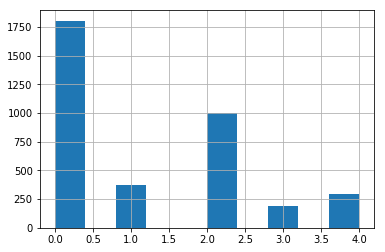

In [196]:
# Histogram of labels: 

train_df['diagnosis'].hist()

Data is very skewed with most values in the 0 or 2 categories. These categories are no diabetic retinopathy or moderate diabetic retinopathy. There are only 193 samples in the 3 category (severe diabetic retinopathy). 

In [197]:
train_disease = train_df
train_disease['disease'] = (train_disease['diagnosis'] > 1).astype(int)

# Breakdown of the labels No Disease vs. Disease: 

train_disease['disease'].value_counts()

0    2175
1    1487
Name: disease, dtype: int64

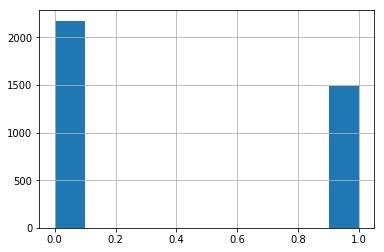

In [198]:
# Histogram of No Disease vs. Disease: 

train_disease['disease'].hist()

When combining categories 1-4 to a single category of disease vs. category 0 for no disease, the uneveness is still viewable. 

In [181]:
x = train_df['id_code']
y = train_df['diagnosis']

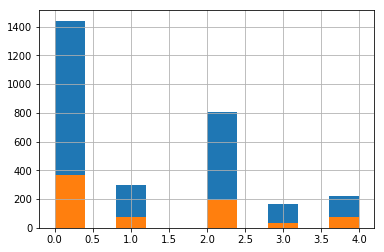

In [9]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(x, y, test_size=0.2,random_state=2)

# Histogram comparing train and test data without augmentation 

Y_train.hist()
Y_test.hist()

### Images from Categories 

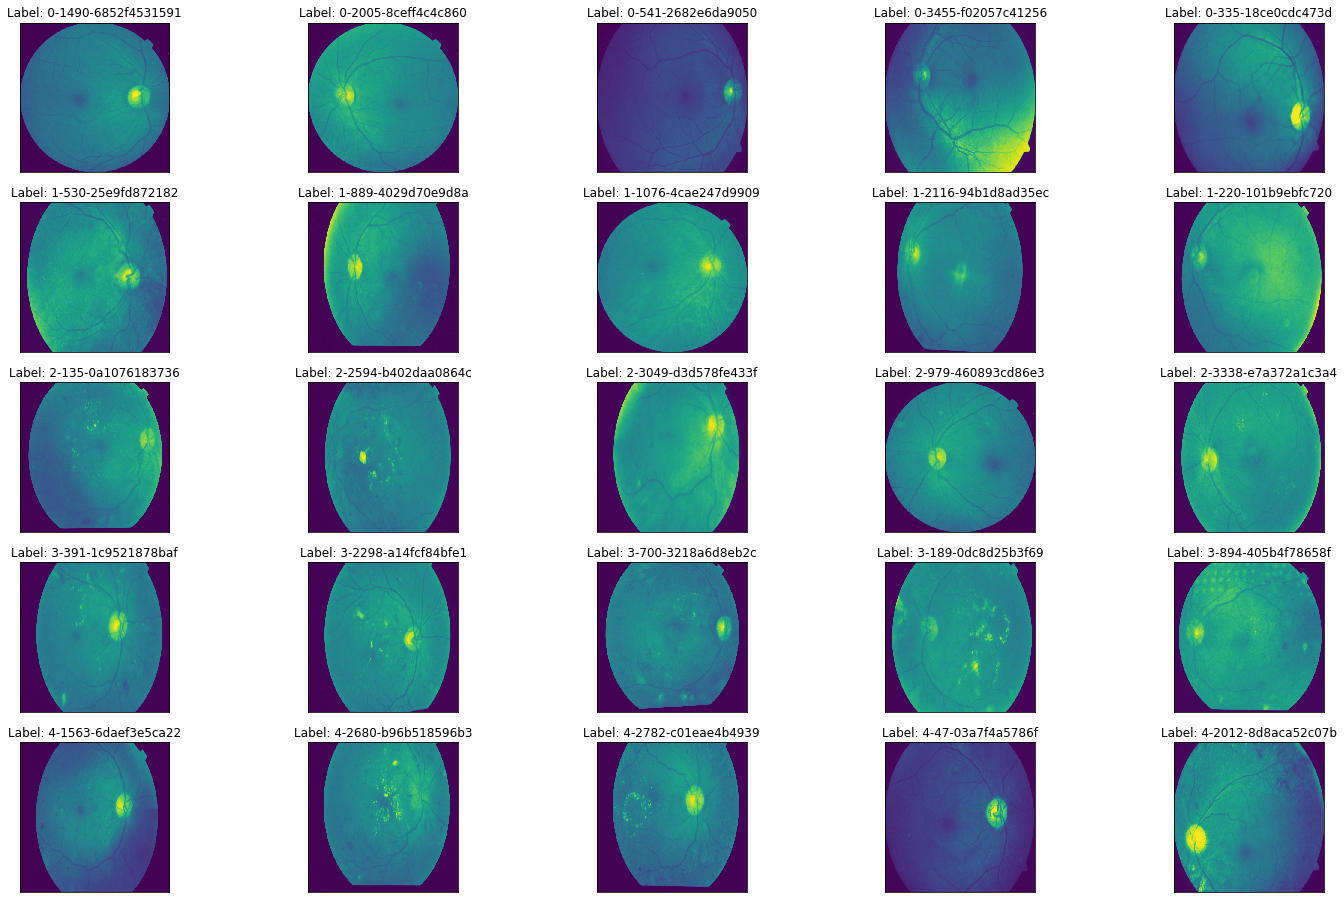

In [10]:
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(Y_train.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(5, random_state=2).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path = f"/project/msca/projects/MLproject/machine_learning/train/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (500, 500))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In this visualization, we can view the differences between each of the categories as well as the variety of images our model will be trained on. Each image is a difffernt color shade, shape, and quality. When determining Diabetic Retinopathy, hemorrhages, hard exudates, abnormal growth of blood vessels, and "cotton wool" spots are used to evaluate the severity of the disease. 

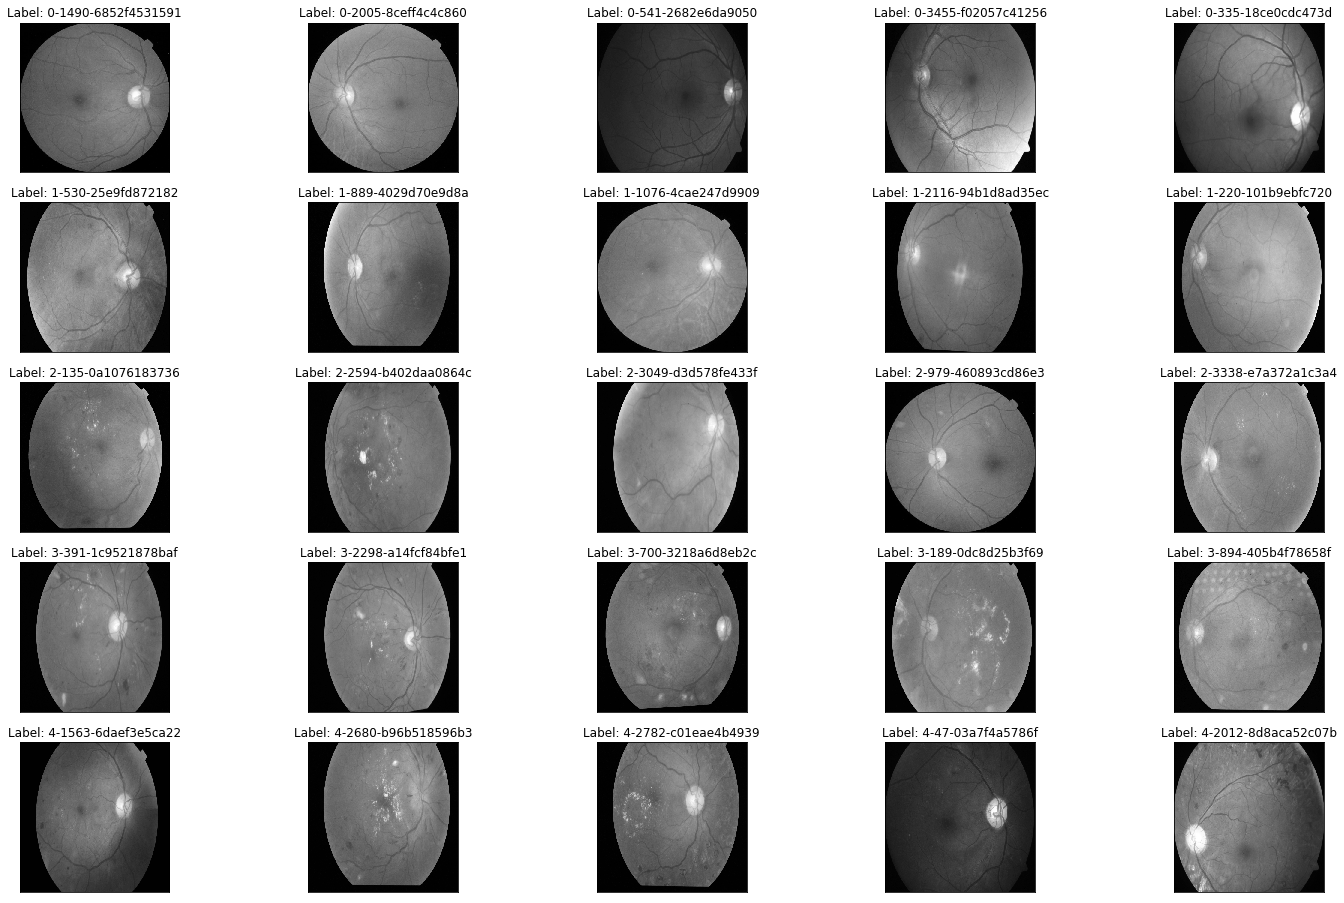

In [11]:
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(Y_train.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(5, random_state=2).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/project/msca/projects/MLproject/machine_learning/train/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (500, 500))

        plt.imshow(image, cmap = 'gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

By viewing in grayscale, we can see the differences more clearly without the distraction of multiple colors. 

### Zoomed in Look at Each Category

##### Category 0: No Diabetic Retinopathy

ID = 2005, Image = 8ceff4c4c860

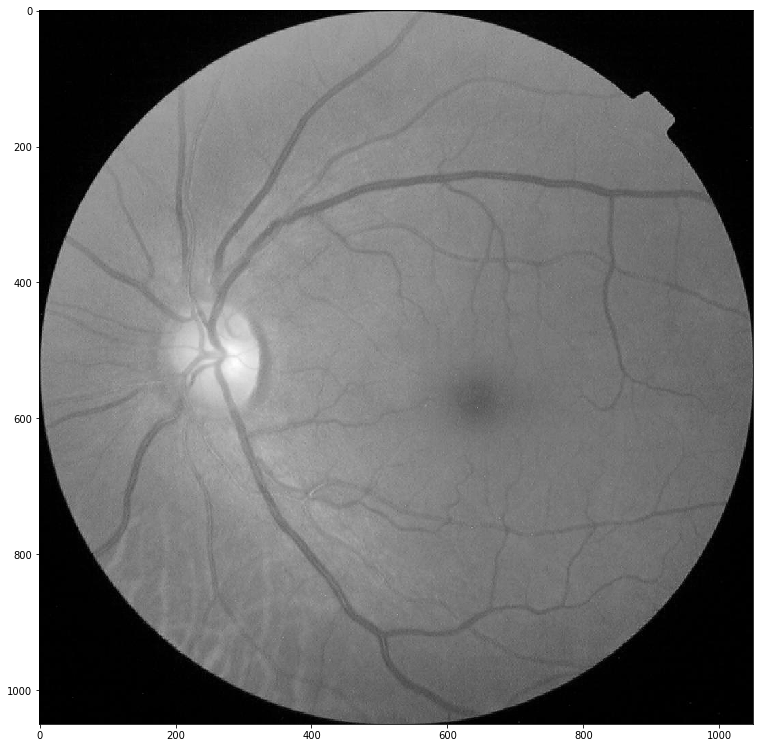

In [12]:
path = f"/project/msca/projects/MLproject/machine_learning/train/8ceff4c4c860.png" 
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape

figsize = (width / float(40))/2, (height / float(40))/2

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

##### Category 1: Mild Diabetic Retinopathy

ID = 1076, Image = 4cae247d9909

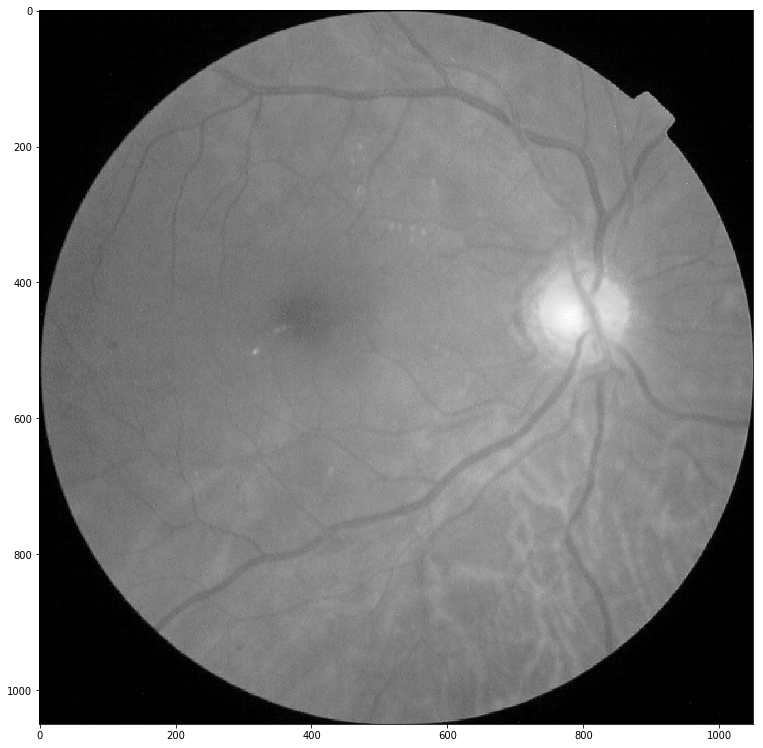

In [13]:
path = f"/project/msca/projects/MLproject/machine_learning/train/4cae247d9909.png" 
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape

figsize = (width / float(40))/2, (height / float(40))/2

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

##### Category 2: Moderate Diabetic Retinopathy

ID = 979, Image = 460893cd86e3

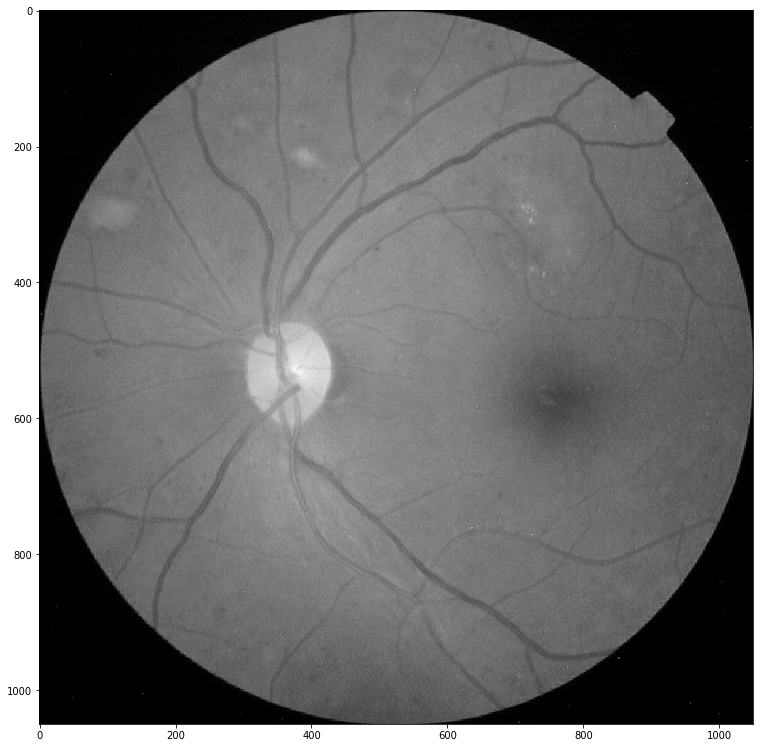

In [14]:
 path = f"/project/msca/projects/MLproject/machine_learning/train/460893cd86e3.png" 

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape

figsize = (width / float(40))/2, (height / float(40))/2

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

##### Category 3: Severe Diabetic Retinopathy

ID = 391, Image = 1c9521878baf

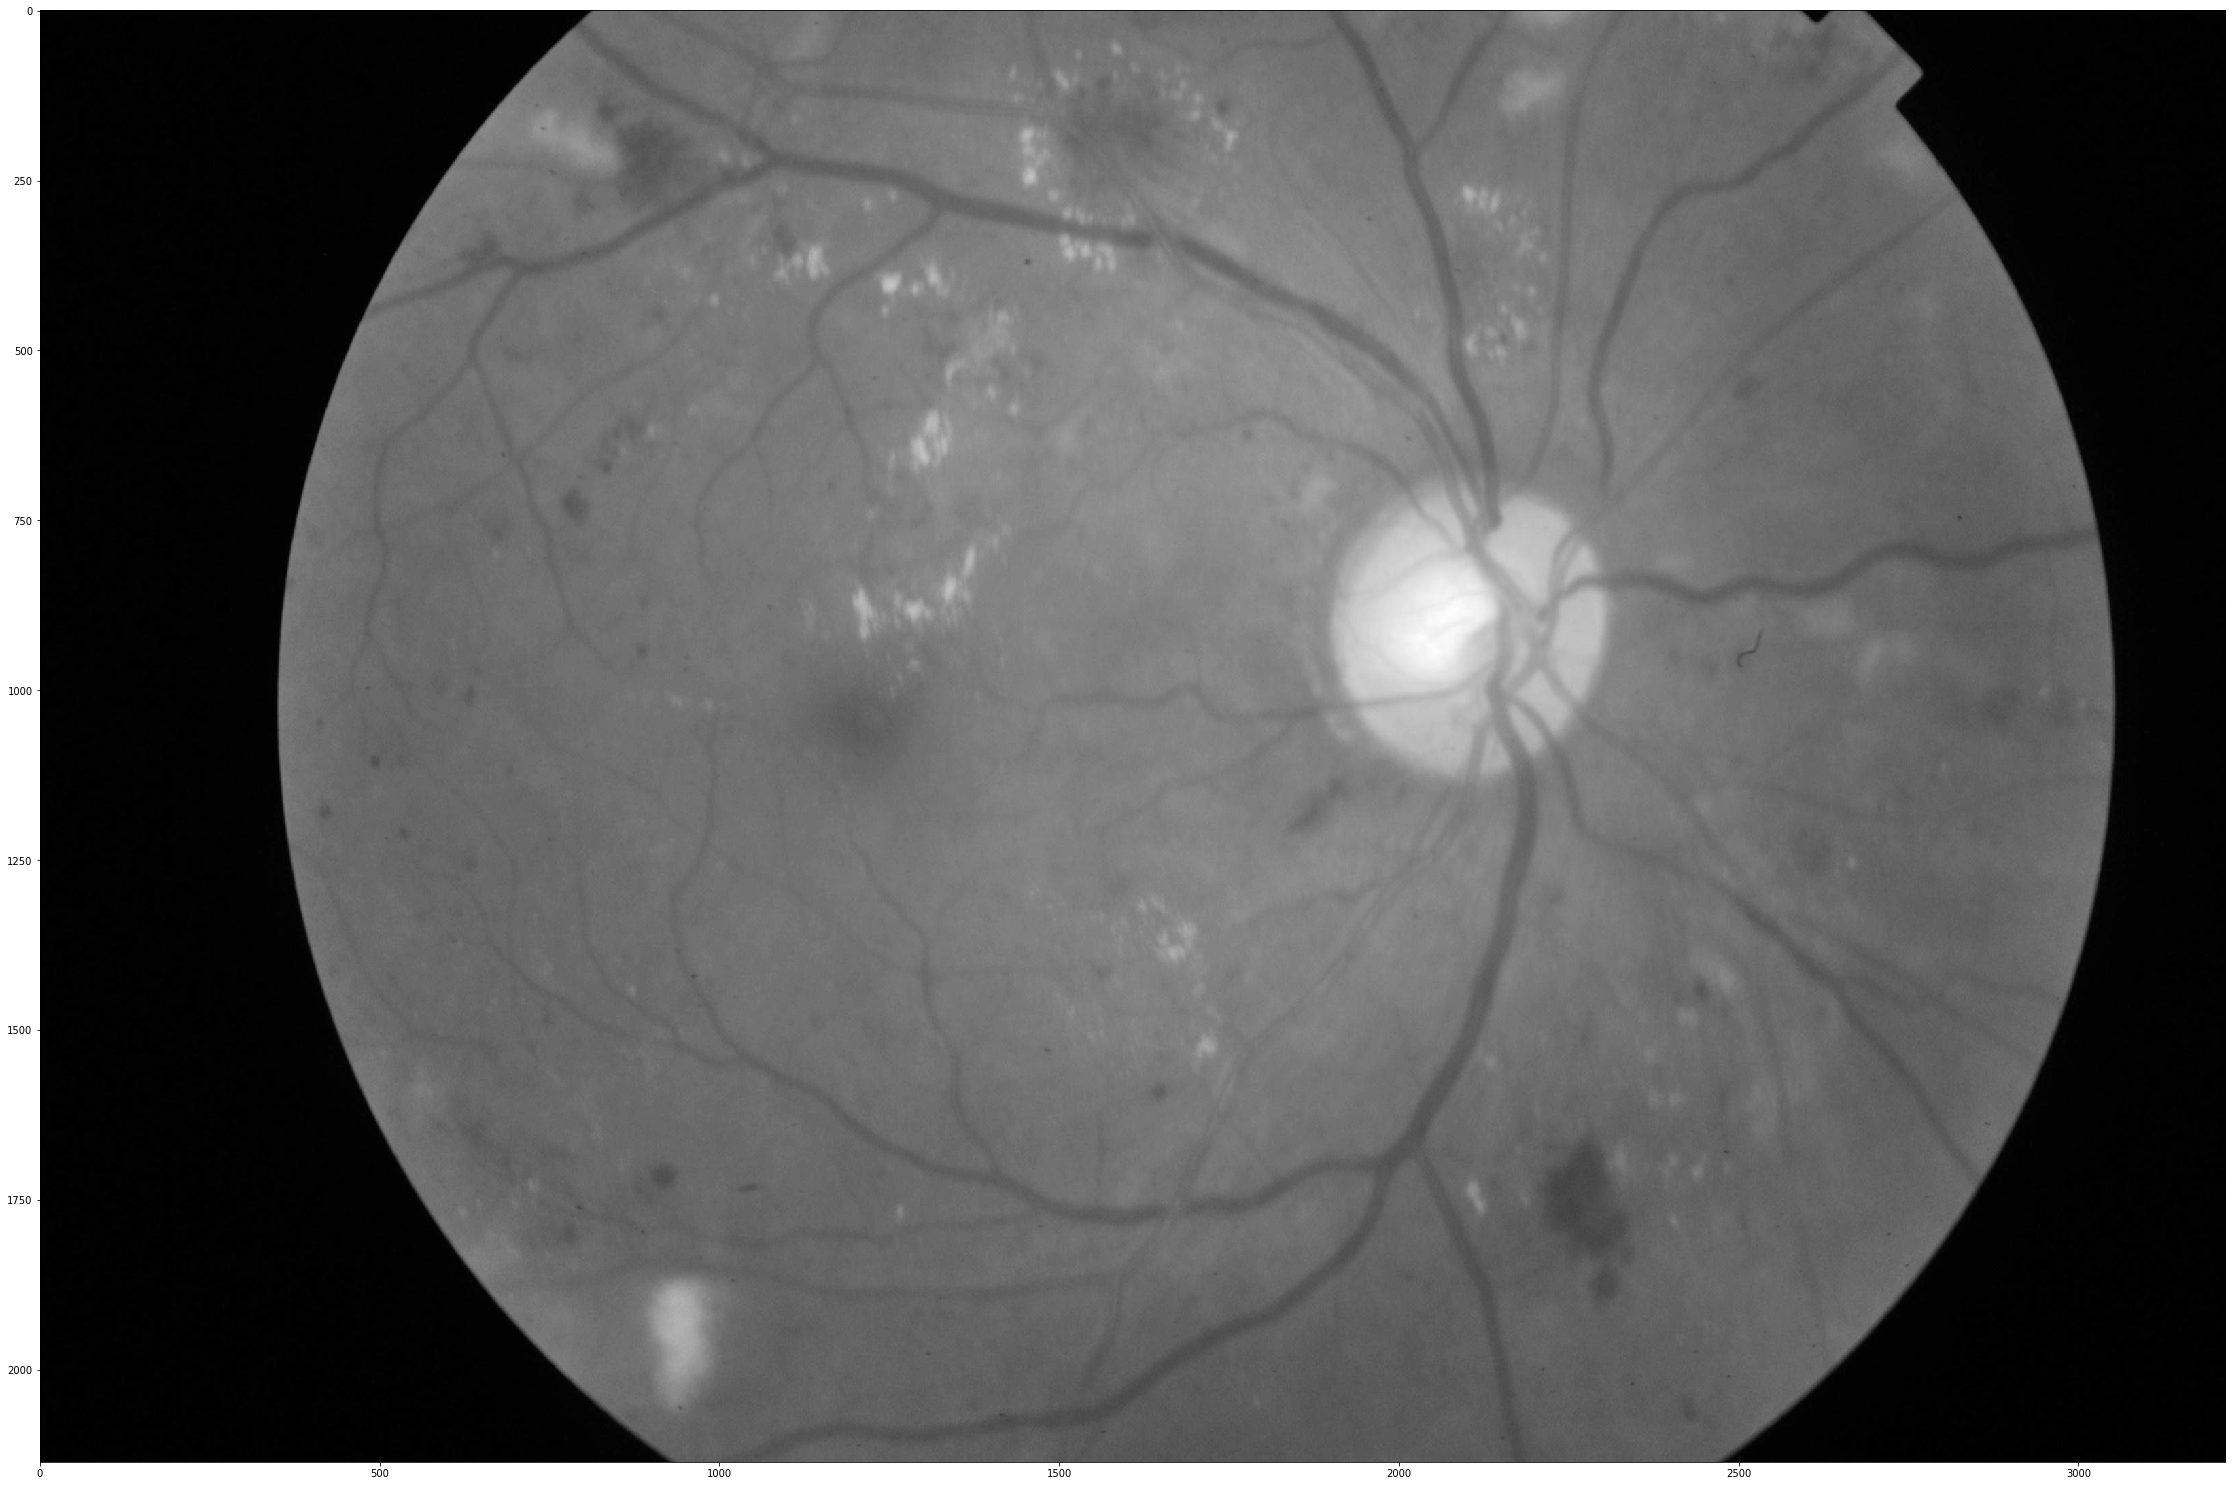

In [15]:
path = f"/project/msca/projects/MLproject/machine_learning/train/1c9521878baf.png" 

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape

figsize = (width / float(40))/2, (height / float(40))/2

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

##### Category 4: Proliferative Diabetic Retinopathy

ID = 2782, Image = c01eae4b4939

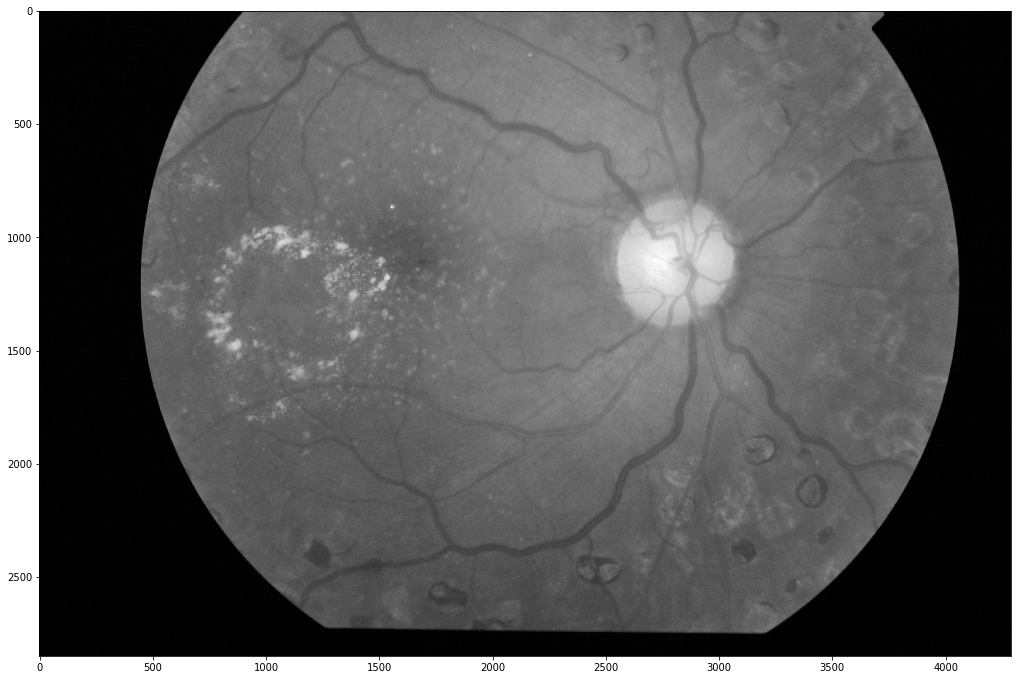

In [16]:
path = f"/project/msca/projects/MLproject/machine_learning/train/c01eae4b4939.png" 

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape

figsize = (width / float(40))/6, (height / float(40))/6

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

# Baseline Models
<a id="BM"> </a>



Run a baseline models before feature engineering. 

## Random Forest Models
<a id="BRF"> </a>

In [17]:
# Read all train images(3662)

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [18]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        train_images_path+image_id+".png"
    )

100%|██████████| 3662/3662 [11:29<00:00,  4.61it/s]


In [22]:
# Generate features for gray images, dim = 3362, 50716 (224*224)

x = np.empty((3662, 50176), dtype=np.uint8) 
for i in range(3662):
    img = x_train[i,:,:,:]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    x[i,:] = img_gray.flatten()

In [23]:
# Train-Test Split

X_train, X_test, Y_train, Y_test = cv.train_test_split(x, y, test_size=0.2, random_state=2)

print(len(X_train))
print(len(Y_train))

2929
2929


In [24]:
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()

original_scaled_X_train = scaler.fit_transform(X_train)
original_scaled_X_test = scaler.transform(X_test)

### Standard Random Forest

In [26]:
# Train random forest classifier

random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto',
           n_estimators=100, n_jobs=1, random_state=2)

# Train the model on training data

random_forest_fit = random_forest.fit(original_scaled_X_train, Y_train)

In [27]:
# Predictions

pred_random_forest = random_forest_fit.predict(original_scaled_X_test)

##### Confusion Matrix

In [28]:
random_forest_confusion = confusion_matrix(Y_test, pred_random_forest)
print(random_forest_confusion)

[[347   4  13   0   0]
 [  7  32  32   2   1]
 [ 13  23 148   5   2]
 [  3   6  16   3   2]
 [  4  15  42   5   8]]


##### Classification Report

In [29]:
classification_report_test = classification_report(Y_test, pred_random_forest)
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       364
           1       0.40      0.43      0.42        74
           2       0.59      0.77      0.67       191
           3       0.20      0.10      0.13        30
           4       0.62      0.11      0.18        74

   micro avg       0.73      0.73      0.73       733
   macro avg       0.55      0.47      0.47       733
weighted avg       0.73      0.73      0.71       733



##### Accuracy

In [30]:
rf_acc = accuracy_score(Y_test, pred_random_forest)

print("Accuracy:", rf_acc)

Accuracy: 0.7339699863574352


#### Check to see if it is overfit

In [31]:
# Predictions for Train Model:

pred_random_forest_train = random_forest_fit.predict(original_scaled_X_train)

In [32]:
random_forest_confusion_train = confusion_matrix(Y_train, pred_random_forest_train)
print(random_forest_confusion_train)

[[1440    1    0    0    0]
 [   2  291    2    0    1]
 [   0    2  805    1    0]
 [   0    0    5  158    0]
 [   0    0    4    2  215]]


In [28]:
classification_report_train = classification_report(Y_train, pred_random_forest_train)
print(classification_report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1441
           1       0.99      0.98      0.99       296
           2       0.99      1.00      0.99       808
           3       0.98      0.97      0.98       163
           4       1.00      0.97      0.98       221

   micro avg       0.99      0.99      0.99      2929
   macro avg       0.99      0.98      0.99      2929
weighted avg       0.99      0.99      0.99      2929



In [29]:
rf_acc_train = accuracy_score(Y_train, pred_random_forest_train)

print("Accuracy:", rf_acc_train)

Accuracy: 0.9931717309662


This model is overfit. 

### Random Forest with TSNE

In [33]:
#apply TSNE for features
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_scaled_X_train = tsne.fit_transform(original_scaled_X_train)
tsne_scaled_X_test = tsne.fit_transform(original_scaled_X_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2929 samples in 7.211s...
[t-SNE] Computed neighbors for 2929 samples in 647.266s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2929
[t-SNE] Computed conditional probabilities for sample 2000 / 2929
[t-SNE] Computed conditional probabilities for sample 2929 / 2929
[t-SNE] Mean sigma: 26.331331
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.523708
[t-SNE] KL divergence after 500 iterations: 0.686861
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 733 samples in 0.671s...
[t-SNE] Computed neighbors for 733 samples in 39.989s...
[t-SNE] Computed conditional probabilities for sample 733 / 733
[t-SNE] Mean sigma: 42.562678
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.654701
[t-SNE] KL divergence after 500 iterations: 0.906653


In [35]:
# Random forest classifier 

random_forest_tsne = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto',
           n_estimators=100, n_jobs=1, random_state=2)

# Fit Model
random_forest_fit_tsne = random_forest_tsne.fit(tsne_scaled_X_train, Y_train)

In [36]:
# Predictions

pred_random_forest_tsne = random_forest_fit_tsne.predict(tsne_scaled_X_test)

##### Confusion Matrix

In [37]:
random_forest_confusion_tsne = confusion_matrix(Y_test, pred_random_forest_tsne)
print(random_forest_confusion_tsne)

[[179  32 137   8   8]
 [ 59   2  13   0   0]
 [147   4  39   1   0]
 [ 19   1  10   0   0]
 [ 52   2  19   0   1]]


##### Classification Report

In [38]:
classification_report_test_tsne = classification_report(Y_test, pred_random_forest_tsne)
print(classification_report_test_tsne)

              precision    recall  f1-score   support

           0       0.39      0.49      0.44       364
           1       0.05      0.03      0.03        74
           2       0.18      0.20      0.19       191
           3       0.00      0.00      0.00        30
           4       0.11      0.01      0.02        74

   micro avg       0.30      0.30      0.30       733
   macro avg       0.15      0.15      0.14       733
weighted avg       0.26      0.30      0.27       733



##### Accuracy Score

In [39]:
rf_tsne_acc = accuracy_score(Y_test, pred_random_forest_tsne)

print("Accuracy:", rf_tsne_acc)

Accuracy: 0.3015006821282401


#### Check to see if it is overfit

In [40]:
pred_random_forest_tsne_train = random_forest_fit_tsne.predict(tsne_scaled_X_train)

In [41]:
random_forest_tsne_confusion_train = confusion_matrix(Y_train, pred_random_forest_tsne_train)
print(random_forest_tsne_confusion_train)

[[1441    0    0    0    0]
 [   0  296    0    0    0]
 [   0    0  808    0    0]
 [   0    0    0  163    0]
 [   0    0    0    0  221]]


In [42]:
classification_random_forest_tsne_train = classification_report(Y_train, pred_random_forest_tsne_train)
print(classification_random_forest_tsne_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1441
           1       1.00      1.00      1.00       296
           2       1.00      1.00      1.00       808
           3       1.00      1.00      1.00       163
           4       1.00      1.00      1.00       221

   micro avg       1.00      1.00      1.00      2929
   macro avg       1.00      1.00      1.00      2929
weighted avg       1.00      1.00      1.00      2929



In [43]:
rf_tsne_acc_train = accuracy_score(Y_train, pred_random_forest_tsne_train)

print("Accuracy:",rf_tsne_acc_train)

Accuracy: 1.0


### Random Forest with PCA

In [45]:
#Apply PCA 
from sklearn.decomposition import PCA

pca = PCA(random_state = 2, n_components=50)
pca_ = pca.fit(original_scaled_X_train)
X_train_pca = pca_.transform(original_scaled_X_train)
X_test_pca = pca_.transform(original_scaled_X_test)

In [46]:
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto',
           n_estimators=100, n_jobs=1, random_state=2)

# Train the model on training data
random_forest_fit_pca = random_forest.fit(X_train_pca, Y_train)

In [47]:
# Predictions
pred_random_forest_pca = random_forest_fit_pca.predict(X_test_pca)

##### Confusion Matrix

In [48]:
random_forest_confusion_pca = confusion_matrix(Y_test, pred_random_forest_pca)
print(random_forest_confusion_pca)

[[350   2  12   0   0]
 [ 15  22  35   2   0]
 [ 20  15 151   3   2]
 [  6   2  18   4   0]
 [ 10   7  47   5   5]]


##### Classification Report

In [49]:
classification_report_test_pca = classification_report(Y_test, pred_random_forest_pca)
print(classification_report_test_pca)

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       364
           1       0.46      0.30      0.36        74
           2       0.57      0.79      0.67       191
           3       0.29      0.13      0.18        30
           4       0.71      0.07      0.12        74

   micro avg       0.73      0.73      0.73       733
   macro avg       0.58      0.45      0.45       733
weighted avg       0.71      0.73      0.68       733



##### Accuracy Score

In [50]:
rf_pca_acc = accuracy_score(Y_test, pred_random_forest_pca)

print("Accuracy:",rf_pca_acc)

Accuracy: 0.7257844474761255


#### Check to see if it is overfit

In [51]:
pred_random_forest_pca_train = random_forest_fit_pca.predict(X_train_pca)

In [52]:
random_forest_pca_confusion_train = confusion_matrix(Y_train, pred_random_forest_pca_train)
print(random_forest_pca_confusion_train)

[[1440    1    0    0    0]
 [   2  291    2    0    1]
 [   0    2  805    1    0]
 [   0    0    5  158    0]
 [   0    0    4    2  215]]


In [53]:
classification_random_forest_pca_train = classification_report(Y_train, pred_random_forest_pca_train)
print(classification_random_forest_pca_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1441
           1       0.99      0.98      0.99       296
           2       0.99      1.00      0.99       808
           3       0.98      0.97      0.98       163
           4       1.00      0.97      0.98       221

   micro avg       0.99      0.99      0.99      2929
   macro avg       0.99      0.98      0.99      2929
weighted avg       0.99      0.99      0.99      2929



In [54]:
rf_pca_acc_train = accuracy_score(Y_train, pred_random_forest_pca_train)

print("Accuracy:",rf_pca_acc_train)

Accuracy: 0.9931717309662


## One vs. Rest with XGBClassifier
<a id="BXGB"> </a>

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

ovr_xgb = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=5, learning_rate = .1, random_state = 2))

ovr_xgb_fit = ovr_xgb.fit(original_scaled_X_train, Y_train)

In [56]:
pred_ovr_xgb = ovr_xgb_fit.predict(original_scaled_X_test)

##### Confusion Matrix

In [57]:
ovr_xgb_fit_confusion = confusion_matrix(Y_test, pred_ovr_xgb)
print(ovr_xgb_fit_confusion)

[[347   2  15   0   0]
 [  9  20  42   2   1]
 [ 13  15 158   4   1]
 [  3   3  19   4   1]
 [  3  14  45   5   7]]


##### Classification Report

In [58]:
classification_ovr_xgb_fit = classification_report(Y_test, pred_ovr_xgb)
print(classification_ovr_xgb_fit)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       364
           1       0.37      0.27      0.31        74
           2       0.57      0.83      0.67       191
           3       0.27      0.13      0.18        30
           4       0.70      0.09      0.17        74

   micro avg       0.73      0.73      0.73       733
   macro avg       0.57      0.46      0.45       733
weighted avg       0.73      0.73      0.70       733



##### Accuracy Score

In [59]:
ovr_xgb_acc = accuracy_score(Y_test, pred_ovr_xgb)

print("Accuracy:", ovr_xgb_acc)

Accuracy: 0.7312414733969986


#### Check to see if it is overfit

In [60]:
pred_ovr_xgb_train = ovr_xgb_fit.predict(original_scaled_X_train)

In [61]:
ovr_xgb_fit_confusion_train = confusion_matrix(Y_train, pred_ovr_xgb_train)
print(ovr_xgb_fit_confusion_train)

[[1438    3    0    0    0]
 [   0  294    2    0    0]
 [   0    2  804    1    1]
 [   0    0    5  156    2]
 [   0    1    3    0  217]]


In [62]:
classification_ovr_xgb_fit_train = classification_report(Y_train, pred_ovr_xgb_train)
print(classification_ovr_xgb_fit_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1441
           1       0.98      0.99      0.99       296
           2       0.99      1.00      0.99       808
           3       0.99      0.96      0.97       163
           4       0.99      0.98      0.98       221

   micro avg       0.99      0.99      0.99      2929
   macro avg       0.99      0.99      0.99      2929
weighted avg       0.99      0.99      0.99      2929



In [66]:
ovr_xgb_acc_train = accuracy_score(Y_train, pred_ovr_xgb_train)

print("Accuracy:",ovr_xgb_acc_train)

Accuracy: 0.9931717309662


## Predicting No Disease vs. Disease
<a id="vs"> </a>


Combine classes 1, 2, 3, and 4 into one class 1 (disease) and run against class 0 (no disease) to see how well the model can predict just the presence of diabetic retinopathy, but not the severity.

In [199]:
y_bin = train_disease['disease']

train_disease.head()

id_code  diagnosis  disease
0  000c1434d8d7          2        1
1  001639a390f0          4        1
2  0024cdab0c1e          1        0
3  002c21358ce6          0        0
4  005b95c28852          0        0

In [166]:
N = train_disease.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_disease['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        train_images_path+image_id+".png"
       #f"/project/msca/projects/MLproject/machine_learning/train/{image_id}.png"
    )

100%|██████████| 3662/3662 [11:21<00:00,  4.26it/s]


In [200]:
# Generate features for gray images, dim = 3362, 50716 (224*224)

x = np.empty((3662, 50176), dtype=np.uint8) 
for i in range(3662):
    img = x_train[i,:,:,:]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    x[i,:] = img_gray.flatten()

In [201]:
# Train-Test Split

X_train_bin, X_test_bin, Y_train_bin, Y_test_bin = cv.train_test_split(x, y_bin, test_size=0.2, random_state=2)

print(len(X_train_bin))
print(len(Y_train_bin))

2929
2929


In [202]:
scaler = StandardScaler()

bin_scaled_X_train = scaler.fit_transform(X_train_bin)
bin_scaled_X_test = scaler.transform(X_test_bin)

### Standard Random Forest

Class 0 vs. Classes 1, 2, 3, 4

In [203]:
# Train random forest classifier

random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto',
           n_estimators=100, n_jobs=1, random_state=2)

# Train the model on training data

random_forest_fit = random_forest.fit(bin_scaled_X_train, Y_train_bin)

In [204]:
# Predictions

pred_random_forest = random_forest_fit.predict(bin_scaled_X_test)

##### Confusion Matrix

In [205]:
random_forest_confusion = confusion_matrix(Y_test_bin, pred_random_forest)
print(random_forest_confusion)

[[357  81]
 [ 30 265]]


##### Classification Report

In [206]:
classification_rf_fit = classification_report(Y_test_bin, pred_random_forest)
print(classification_rf_fit)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       438
           1       0.77      0.90      0.83       295

   micro avg       0.85      0.85      0.85       733
   macro avg       0.84      0.86      0.85       733
weighted avg       0.86      0.85      0.85       733



##### Accuracy

In [207]:
bin_rf_acc = accuracy_score(Y_test_bin, pred_random_forest)

print("Accuracy:", bin_rf_acc)

Accuracy: 0.8485675306957708


#### Check to see if it is overfit

In [208]:
# Predictions for Train Model:

pred_random_forest_train = random_forest_fit.predict(bin_scaled_X_train)

In [209]:
random_forest_confusion_train = confusion_matrix(Y_train_bin, pred_random_forest_train)
print(random_forest_confusion_train)

[[1733    4]
 [   1 1191]]


In [210]:
classification_report_train = classification_report(Y_train_bin, pred_random_forest_train)
print(classification_report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1737
           1       1.00      1.00      1.00      1192

   micro avg       1.00      1.00      1.00      2929
   macro avg       1.00      1.00      1.00      2929
weighted avg       1.00      1.00      1.00      2929



In [211]:
bin_rf_acc_train = accuracy_score(Y_train_bin, pred_random_forest_train)

print("Accuracy:", bin_rf_acc_train)

Accuracy: 0.9982929327415501


### One vs. Rest with XGBClassifier

In [212]:
ovr_xgb = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=5, learning_rate = .1, random_state = 2))

ovr_xgb_fit = ovr_xgb.fit(bin_scaled_X_train, Y_train_bin)

In [221]:
# predictions
pred_ovr_xgb = ovr_xgb_fit.predict(bin_scaled_X_test)

##### Confusion Matrix

In [222]:
ovr_xgb_fit_confusion = confusion_matrix(Y_test_bin, pred_ovr_xgb)
print(ovr_xgb_fit_confusion)

[[365  73]
 [ 32 263]]


##### Classification Report

In [223]:
classification_ovr_xgb_fit = classification_report(Y_test_bin, pred_ovr_xgb)
print(classification_ovr_xgb_fit)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       438
           1       0.78      0.89      0.83       295

   micro avg       0.86      0.86      0.86       733
   macro avg       0.85      0.86      0.85       733
weighted avg       0.86      0.86      0.86       733



##### Accuracy

In [224]:
bin_ovr_xgb_acc = accuracy_score(Y_test_bin, pred_ovr_xgb)

print("Accuracy:", bin_ovr_xgb_acc)

Accuracy: 0.8567530695770805


#### Check to see if it is overfit

In [225]:
pred_ovr_xgb_train = ovr_xgb_fit.predict(bin_scaled_X_train)

In [226]:
ovr_xgb_fit_confusion_train = confusion_matrix(Y_train_bin, pred_ovr_xgb_train)
print(ovr_xgb_fit_confusion_train)

[[1731    6]
 [   1 1191]]


In [227]:
classification_ovr_xgb_fit_train = classification_report(Y_train_bin, pred_ovr_xgb_train)
print(classification_ovr_xgb_fit_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1737
           1       0.99      1.00      1.00      1192

   micro avg       1.00      1.00      1.00      2929
   macro avg       1.00      1.00      1.00      2929
weighted avg       1.00      1.00      1.00      2929



In [228]:
bin_ovr_xgb_acc_train = accuracy_score(Y_train_bin, pred_ovr_xgb_train)

print("Accuracy:",bin_ovr_xgb_acc_train)

Accuracy: 0.99761010583817


# Data Augmentation
<a id="Augmentation"> </a>

Due to the unevenness, we will need to create new images based on different types of augmentation. Each class will have a mix between original images and augmented imaged. Classes 0 and 2 will need to be downsampled because these classes have the most images. Classes 1, 3, and 4 will be upsampled. At the end of augmentation, each class will have around 1000 images that will then be split into train and test. 

In [67]:
# Create augmented_train_df.csv:

cols = [["id_code","diagnosis"]]

with open(project_path+"augmented_train_df.csv", 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(cols)
    
writeFile.close()
    

In [68]:
# Load augmented image names and labels:

augmented_train_df = pd.read_csv(project_path+"augmented_train_df.csv")
augmented_train_df.head(5)

Empty DataFrame
Columns: [id_code, diagnosis]
Index: []

In [69]:
# Create test_df.csv:

cols = [["id_code","diagnosis"]]

with open(project_path+"test_df.csv", 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(cols)
    
writeFile.close()
    

In [70]:
# Load test image names and labels:

test_df = pd.read_csv(project_path+"test_df.csv")
test_df.head(5)

Empty DataFrame
Columns: [id_code, diagnosis]
Index: []

In [71]:
# Image Preprocessing

def preprocess_image(image_path, image_size):
    im = Image.open(image_path)
    im = im.resize((image_size, )*2, resample=Image.LANCZOS)
    return im

In [72]:
# Image Loading

def load_images(image_names_and_labels_df, image_size, image_path, class_label="all"):
    # for loading images irrespective of class:
    if class_label=="all":
        number_of_images = image_names_and_labels_df.shape[0]
        X = np.empty((number_of_images, image_size, image_size, 3), dtype=np.uint8)
        for i, image_id in enumerate(tqdm(image_names_and_labels_df['id_code'], mininterval=10, leave = False)):
            X[i, :, :, :] = preprocess_image(image_path+image_id+".png", image_size)
        return X
    # for loading images of a particular class:
    else:
        truncated_df = image_names_and_labels_df[image_names_and_labels_df['diagnosis']==class_label]
        number_of_images = truncated_df.shape[0]
        X = np.empty((number_of_images, image_size, image_size, 3), dtype=np.uint8)
        for i, image_id in enumerate(tqdm(truncated_df['id_code'], mininterval=10, leave = False)):
            X[i, :, :, :] = preprocess_image(image_path+image_id+".png", image_size)
        return X
   

In [73]:
#test_load = load_images(train_df, 224, train_images_path, class_label=3)


In [74]:
# Randomly sample a class of labels from data frame:

def random_image_sample(class_label, image_names_and_labels_df, sample_size, number_of_samples, replace=False):
    resulting_frames = []
    for i in range(number_of_samples):
        sampled_frame = image_names_and_labels_df[image_names_and_labels_df['diagnosis']==class_label].sample(replace=replace, n = sample_size)
        # Append randomly sampled dataframes to list:
        resulting_frames.append(sampled_frame)
    return resulting_frames
    

In [75]:
# Image Rotation: 

def rotate_image(image):
    rotated = ndimage.rotate(image, np.random.randint(0,359))
    return rotated

In [76]:
# Image Flip:

def flip_image(image):
    flipped = np.flipud(image)
    return flipped



In [77]:
# Poisson Noise:

def noise(image):
    noisier = skimage.util.random_noise(image, "poisson")
    return noisier
    

In [78]:
# Sharpen: 

def sharpen_image(image):
    sharpened = Image.fromarray(image).filter(UnsharpMask(radius=2, percent=100, threshold=3))
    return sharpened

In [79]:
# Augment Images:

def augment_images(class_label, image_names_and_labels_df, image_size, sample_size, image_path, augmented_images_path, number_of_samples=4, augmentation_type="all",replace=False):
    
    with open(project_path+"augmented_train_df.csv", 'a') as writeFile:
        writer = csv.writer(writeFile)
        # Generate a list of randomly sampled dataframes given a class label:
        resulting_frames = random_image_sample(class_label, image_names_and_labels_df, sample_size, number_of_samples, replace=replace)
        
        # Using list of dataframes, generate a list of image ndarrays with length equivalent to the 
        # number of random samples taken:
        images = [load_images(resulting_frames[i], image_size, image_path, class_label=class_label) for i in range(len(resulting_frames))]
        
        # Assuming we are generating the same number of samples that we have augmentation functions:
        if augmentation_type=="all" and number_of_samples==4:
      
            # Generate and save rotated images and their corresponding filenames/class labels:
            for i in range(sample_size):
                new_name = resulting_frames[0].iloc[i,0]+"_rotated_"+str(i) # Generates new file name
                writer.writerows([[new_name,resulting_frames[0].iloc[i,1]]]) # Writes new file name and corresponding label to csv
                Image.fromarray(rotate_image(images[0][i])).save(augmented_images_path+"{}.png".format(new_name)) # Saves new image to directory with new file name
            
            # Generate and save flipped images and their corresponding filenames/class labels:
            for i in range(sample_size):
                new_name = resulting_frames[1].iloc[i,0]+"_flipped_"+str(i)
                writer.writerows([[new_name,resulting_frames[1].iloc[i,1]]])
                Image.fromarray(flip_image(images[1][i])).save(augmented_images_path+"{}.png".format(new_name))
                
            # Generate and save noisy images and their corresponding filenames/class labels:
            for i in range(sample_size):
                new_name = resulting_frames[2].iloc[i,0]+"_noisier_"+str(i)
                writer.writerows([[new_name,resulting_frames[2].iloc[i,1]]])
                Image.fromarray((noise(images[2][i])*255).astype(np.uint8)).save(augmented_images_path+"{}.png".format(new_name))
                
            # Generate and save sharpened images and their corresponding filenames/class labels:
            for i in range(sample_size):
                new_name = resulting_frames[3].iloc[i,0]+"_sharpened_"+str(i)
                writer.writerows([[new_name,resulting_frames[3].iloc[i,1]]])
                sharpen_image(images[3][i]).save(augmented_images_path+"{}.png".format(new_name))
            
        else:
            print("You get no images!")
    
    writeFile.close()

In [80]:
# Downsample Labels (for over-represented labels):

def downsample(class_label, image_names_and_labels_df, image_size, sample_size, image_path, augmented_images_path, replace=False):
     
    with open(project_path+"augmented_train_df.csv", 'a') as writeFile:
        writer = csv.writer(writeFile)
        # Generate a list of randomly sampled dataframes given a class label:
        resulting_frames = random_image_sample(class_label, image_names_and_labels_df, sample_size, number_of_samples=1, replace=replace)
        
        # Using list of dataframes, generate a list of image ndarrays with length equivalent to the 
        # number of random samples taken:
        images = load_images(resulting_frames[0], image_size, image_path, class_label=class_label)
        
        for i in range(sample_size):
                image_name = resulting_frames[0].iloc[i,0] # Uses original name
                writer.writerows([[image_name,resulting_frames[0].iloc[i,1]]]) # Writes file name and corresponding label to csv
                Image.fromarray(rotate_image(images[i])).save(augmented_images_path+"{}.png".format(image_name)) # Saves image to directory with file name
    
    writeFile.close()
        

In [81]:
# Move Images (for under-represented labels):

def move_images(class_label, image_names_and_labels_df, image_size, from_path, to_path, append_to_csv_name="augmented_train_df.csv"):
    
    with open(project_path+append_to_csv_name, 'a') as writeFile:
        writer = csv.writer(writeFile)
        
        names_and_labels = image_names_and_labels_df[image_names_and_labels_df['diagnosis']==class_label]
        
        images = load_images(image_names_and_labels_df, image_size, from_path, class_label=class_label)
        
        for i in range(len(names_and_labels)):
                image_name = names_and_labels.iloc[i,0] # Uses original name
                writer.writerows([[image_name,names_and_labels.iloc[i,1]]]) # Writes file name and corresponding label to csv
                Image.fromarray(rotate_image(images[i])).save(to_path+"{}.png".format(image_name)) # Saves image to directory with file name
    
    writeFile.close()
    

In [82]:
# Form a test set:

def test_split(augmented_train_df, augmented_images_path, test_images_path, test_size, image_size):
    
    with open(project_path+"augmented_train_df.csv", 'w') as overwriteFile:
        writer = csv.writer(overwriteFile)
        
        rows_to_remove = pd.DataFrame(columns=['id_code', 'diagnosis'])
        for i in range(5):
            test_sample_size = round(len(augmented_train_df[augmented_train_df['diagnosis']==i])*test_size)
            random_frame = random_image_sample(class_label=i, image_names_and_labels_df=augmented_train_df, sample_size=test_sample_size, number_of_samples=1, replace=False)[0]
            move_images(class_label=i, image_names_and_labels_df=random_frame, image_size=image_size, from_path=augmented_images_path, to_path=test_images_path, append_to_csv_name="test_df.csv")
            rows_to_remove = rows_to_remove.append(random_frame)
        new_augmented_train_df = augmented_train_df[~augmented_train_df['id_code'].isin(list(rows_to_remove['id_code']))]
        new_augmented_train_df.to_csv(project_path+"augmented_train_df.csv", index = False)
        fileList = glob.glob(augmented_images_path+"*.png")
        for file in fileList:
            if file[-16:-4] in rows_to_remove["id_code"].tolist():
                os.remove(file)
            
    

In [83]:
# Run move_image functions:

move_images(class_label=1, image_names_and_labels_df=train_df, image_size=100, from_path=train_images_path, to_path=augmented_images_path)
move_images(class_label=3, image_names_and_labels_df=train_df, image_size=100, from_path=train_images_path, to_path=augmented_images_path)
move_images(class_label=4, image_names_and_labels_df=train_df, image_size=100, from_path=train_images_path, to_path=augmented_images_path)



In [84]:
# Run downsample functions:

downsample(class_label=0, image_names_and_labels_df=train_df, image_size=100, sample_size=600, image_path=train_images_path, augmented_images_path=augmented_images_path, replace=False)
downsample(class_label=2, image_names_and_labels_df=train_df, image_size=100, sample_size=600, image_path=train_images_path, augmented_images_path=augmented_images_path, replace=False)

In [85]:
# Reload augumented_train_df given updates made to corresponding csv above:

augmented_train_df = pd.read_csv(project_path+"augmented_train_df.csv")
augmented_train_df.shape

(2058, 2)

In [86]:
# Randomly pull out a certain percentage for testing and move them to the test folder:

test_split(augmented_train_df=augmented_train_df, augmented_images_path=augmented_images_path, test_images_path=test_images_path, test_size=0.10, image_size=100)


In [87]:
# Reload augumented_train_df given updates made to corresponding csv above:

augmented_train_df = pd.read_csv(project_path+"augmented_train_df.csv")
augmented_train_df.shape

(1852, 2)

In [88]:
# Run augmentation functions:

augment_images(class_label=0, image_names_and_labels_df=augmented_train_df, image_size=50, sample_size=90, image_path=augmented_images_path, augmented_images_path=augmented_images_path, number_of_samples=4, augmentation_type="all", replace=False)
augment_images(class_label=1, image_names_and_labels_df=augmented_train_df, image_size=50, sample_size=141, image_path=augmented_images_path, augmented_images_path=augmented_images_path, number_of_samples=4, augmentation_type="all", replace=False)
augment_images(class_label=2, image_names_and_labels_df=augmented_train_df, image_size=50, sample_size=90, image_path=augmented_images_path, augmented_images_path=augmented_images_path, number_of_samples=4, augmentation_type="all", replace=False)
augment_images(class_label=3, image_names_and_labels_df=augmented_train_df, image_size=50, sample_size=181, image_path=augmented_images_path, augmented_images_path=augmented_images_path, number_of_samples=4, augmentation_type="all", replace=True)
augment_images(class_label=4, image_names_and_labels_df=augmented_train_df, image_size=50, sample_size=158, image_path=augmented_images_path, augmented_images_path=augmented_images_path, number_of_samples=4, augmentation_type="all", replace=False)

# To augment images, specify:
    #class_label: For which class label (0 to 4) you would like to augment images
    #image_names_and_labels_df: dataframe including image names in the first column and class labels in the second column
    #image_size: height/width dimensions of image
    #sample_size: size of random samples to be drawn from a particular class label and for one of the four types of augmentation
    #image_path: original directory of image files
    #augmented_images_path: directory to which you will save augmented images
    #number_of_samples: the number of random samples of sample size 'sample_size' that you will be taking (often will correspond to number of augmentation techniques)
    #augmentation_type: if "all", all augmentations available in this function (eventually, rotate, flip, sharpen, and gaussian) will be applied


In [89]:
augmented_train_df = pd.read_csv(project_path+"augmented_train_df.csv")
print("Final Number of Train Images:",augmented_train_df.shape[0])
test_df = pd.read_csv(project_path+"test_df.csv")
print("Final Number of Test Images:",test_df.shape[0])

Final Number of Train Images: 4492
Final Number of Test Images: 206


# Modeling
<a id="Modeling"> </a>

In [90]:
import numpy as np
import pandas as pd

import os
import glob

import cv2
from PIL import Image
    
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as cv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


In [91]:
# Image Preprocessing:

def preprocess_image(image_path, image_size):
    im = Image.open(image_path)
    im = im.resize((image_size, )*2, resample=Image.LANCZOS)
    return im

In [92]:
# Image Loading:

def load_images(image_names_and_labels_df, image_size, image_path, class_label="all"):
    # for loading images irrespective of class:
    if class_label=="all":
        number_of_images = image_names_and_labels_df.shape[0]
        X = np.empty((number_of_images, image_size, image_size, 3), dtype=np.uint8)
        for i, image_id in enumerate(tqdm(image_names_and_labels_df['id_code'], mininterval=10, leave = False)):
            X[i, :, :, :] = preprocess_image(image_path+image_id+".png", image_size)
        return X
    # for loading images of a particular class:
    else:
        truncated_df = image_names_and_labels_df[image_names_and_labels_df['diagnosis']==class_label]
        number_of_images = truncated_df.shape[0]
        X = np.empty((number_of_images, image_size, image_size, 3), dtype=np.uint8)
        for i, image_id in enumerate(tqdm(truncated_df['id_code'], mininterval=10, leave = False)):
            X[i, :, :, :] = preprocess_image(image_path+image_id+".png", image_size)
        return X
   

In [93]:
# Read in training data:

y_train = pd.read_csv(project_path + "augmented_train_df.csv")
X_train = load_images(image_names_and_labels_df=y_train, image_size=5, image_path=augmented_images_path, class_label="all")
X_train = np.array([X_train[i].flatten() for i in range(len(X_train))])
y_train = np.array(list(map(str,y_train.iloc[:,1])))

In [94]:
# Read in testing data:

y_test = pd.read_csv(project_path + "test_df.csv")
X_test = load_images(image_names_and_labels_df=y_test, image_size=5, image_path=test_images_path, class_label="all")
X_test = np.array([X_test[i].flatten() for i in range(len(X_test))])
y_test = np.array(list(map(str,y_test.iloc[:,1])))


In [95]:
# Scaling inputs:

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Random Forest Models
<a id="RF"> </a>

In [96]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

N = augmented_train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(augmented_train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
       #f"/project/msca/projects/MLproject/machine_learning/augmented_train/{image_id}.png"
        augmented_images_path+image_id+".png"
    )
    

X_train_new = np.empty((4492, 50176), dtype=np.uint8) #50176 = 224*224
for i in range(4492):
    img = x_train[i,:,:,:]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train_new[i,:] = img_gray.flatten()

100%|██████████| 4492/4492 [00:07<00:00, 563.98it/s]


In [97]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
       #f"/project/msca/projects/MLproject/machine_learning/test/{image_id}.png"
        test_images_path+image_id+".png"
    )
    

X_test_new = np.empty((206, 50176), dtype=np.uint8) #50176 = 224*224
for i in range(206):
    img = x_test[i,:,:,:]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_test_new[i,:] = img_gray.flatten()

100%|██████████| 206/206 [00:00<00:00, 452.85it/s]


In [98]:
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train_new)
scaled_X_test = scaler.transform(X_test_new)

### Standard Random Forest

In [99]:
# Random forest classifier 

random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto',
           n_estimators=100, n_jobs=1, random_state=2)

In [100]:
# Fit the model 

random_forest_fit = random_forest.fit(scaled_X_train, y_train)

In [101]:
# Predictions

pred_random_forest = random_forest_fit.predict(scaled_X_test)

##### Confusion Matrix

In [102]:
random_forest_confusion = confusion_matrix(y_test, pred_random_forest)
print(random_forest_confusion)

[[53  0  1  0  6]
 [13 13  3  5  3]
 [17 12  8 12 11]
 [ 7  4  1  6  1]
 [ 7  9  5  1  8]]


##### Classification Report

In [103]:
classification_report_test = classification_report(y_test, pred_random_forest)
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.55      0.88      0.68        60
           1       0.34      0.35      0.35        37
           2       0.44      0.13      0.21        60
           3       0.25      0.32      0.28        19
           4       0.28      0.27      0.27        30

   micro avg       0.43      0.43      0.43       206
   macro avg       0.37      0.39      0.36       206
weighted avg       0.41      0.43      0.38       206



##### Accuracy

In [104]:
aug_rf_acc = accuracy_score(y_test, pred_random_forest)

print("Accuracy:", aug_rf_acc)

Accuracy: 0.42718446601941745


#### Check to see if it is overfit

In [105]:
pred_random_forest_train = random_forest_fit.predict(scaled_X_train)

In [106]:
random_forest_confusion_train = confusion_matrix(y_train, pred_random_forest_train)
print(random_forest_confusion_train)

[[900   0   0   0   0]
 [  0 897   0   0   0]
 [  0   0 900   0   0]
 [  0   0   0 898   0]
 [  0   0   0   0 897]]


In [107]:
classification_random_forest_train = classification_report(y_train, pred_random_forest_train)
print(classification_random_forest_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       1.00      1.00      1.00       897
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       898
           4       1.00      1.00      1.00       897

   micro avg       1.00      1.00      1.00      4492
   macro avg       1.00      1.00      1.00      4492
weighted avg       1.00      1.00      1.00      4492



In [108]:
aug_rf_acc_train = accuracy_score(y_train, pred_random_forest_train)

print("Accuracy:",aug_rf_acc_train)

Accuracy: 1.0


### Random Forest with TSNE

In [109]:
#apply TSNE for features
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_scaled_X_train = tsne.fit_transform(scaled_X_train)
tsne_scaled_X_test = tsne.fit_transform(scaled_X_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4492 samples in 12.445s...
[t-SNE] Computed neighbors for 4492 samples in 1525.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4492
[t-SNE] Computed conditional probabilities for sample 2000 / 4492
[t-SNE] Computed conditional probabilities for sample 3000 / 4492
[t-SNE] Computed conditional probabilities for sample 4000 / 4492
[t-SNE] Computed conditional probabilities for sample 4492 / 4492
[t-SNE] Mean sigma: 40.707502
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.176109
[t-SNE] KL divergence after 500 iterations: 1.151619
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.004s...
[t-SNE] Computed neighbors for 206 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 55.637624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.483185
[t-SNE] KL divergence after 500 iterations: 1.9011

In [110]:
# Random forest classifier 

random_forest_tsne = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto',
           n_estimators=100, n_jobs=1, random_state=2)

# Fit Model
random_forest_fit_tsne = random_forest_tsne.fit(tsne_scaled_X_train, y_train)

In [111]:
# Predictions

pred_random_forest_tsne = random_forest_fit_tsne.predict(tsne_scaled_X_test)

##### Confusion Matrix

In [112]:
random_forest_confusion_tsne = confusion_matrix(y_test, pred_random_forest_tsne)
print(random_forest_confusion_tsne)

[[38  2  4 11  5]
 [15  2  8 10  2]
 [37  1  1 18  3]
 [15  1  0  2  1]
 [17  1  1  9  2]]


##### Classification Report

In [113]:
classification_report_test_tsne = classification_report(y_test, pred_random_forest_tsne)
print(classification_report_test_tsne)

              precision    recall  f1-score   support

           0       0.31      0.63      0.42        60
           1       0.29      0.05      0.09        37
           2       0.07      0.02      0.03        60
           3       0.04      0.11      0.06        19
           4       0.15      0.07      0.09        30

   micro avg       0.22      0.22      0.22       206
   macro avg       0.17      0.18      0.14       206
weighted avg       0.19      0.22      0.16       206



##### Accuracy Score

In [114]:
aug_rf_tsne_acc = accuracy_score(y_test, pred_random_forest_tsne)

print("Accuracy:",aug_rf_tsne_acc)

Accuracy: 0.21844660194174756


#### Check to see if it is overfit

In [115]:
pred_random_forest_tsne_train = random_forest_fit_tsne.predict(tsne_scaled_X_train)

In [116]:
random_forest_tsne_confusion_train = confusion_matrix(y_train, pred_random_forest_tsne_train)
print(random_forest_tsne_confusion_train)

[[900   0   0   0   0]
 [  0 897   0   0   0]
 [  0   0 900   0   0]
 [  0   0   0 898   0]
 [  0   0   0   0 897]]


In [117]:
classification_random_forest_tsne_train = classification_report(y_train, pred_random_forest_tsne_train)
print(classification_random_forest_tsne_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       1.00      1.00      1.00       897
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       898
           4       1.00      1.00      1.00       897

   micro avg       1.00      1.00      1.00      4492
   macro avg       1.00      1.00      1.00      4492
weighted avg       1.00      1.00      1.00      4492



In [118]:
aug_rf_tsne_acc_train = accuracy_score(y_train, pred_random_forest_tsne_train)

print("Accuracy:",aug_rf_tsne_acc_train)

Accuracy: 1.0


### Random Forest with PCA

In [119]:
#Apply PCA 
from sklearn.decomposition import PCA

pca = PCA(random_state = 2, n_components=50)
pca_ = pca.fit(scaled_X_train)
X_train_pca = pca_.transform(scaled_X_train)
X_test_pca = pca_.transform(scaled_X_test)

In [120]:
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto',
           n_estimators=100, n_jobs=1, random_state=2)

# Train the model on training data
random_forest_fit_pca = random_forest.fit(X_train_pca, y_train)

In [121]:
# Predictions
pred_random_forest_pca = random_forest_fit_pca.predict(X_test_pca)

##### Confusion Matrix

In [122]:
random_forest_confusion_pca = confusion_matrix(y_test, pred_random_forest_pca)
print(random_forest_confusion_pca)

[[41  8  1  6  4]
 [ 7 12  4  8  6]
 [ 6 16 12 18  8]
 [ 4  4  1  6  4]
 [ 7  7  5  5  6]]


##### Classification Report

In [123]:
classification_report_test_pca = classification_report(y_test, pred_random_forest_pca)
print(classification_report_test_pca)

              precision    recall  f1-score   support

           0       0.63      0.68      0.66        60
           1       0.26      0.32      0.29        37
           2       0.52      0.20      0.29        60
           3       0.14      0.32      0.19        19
           4       0.21      0.20      0.21        30

   micro avg       0.37      0.37      0.37       206
   macro avg       0.35      0.34      0.33       206
weighted avg       0.43      0.37      0.37       206



##### Accuracy Score

In [124]:
aug_rf_pca_acc = accuracy_score(y_test, pred_random_forest_pca)

print("Accuracy:",aug_rf_pca_acc)

Accuracy: 0.3737864077669903


#### Check to see if it is overfit

In [125]:
pred_random_forest_pca_train = random_forest_fit_pca.predict(X_train_pca)

In [126]:
random_forest_pca_confusion_train = confusion_matrix(y_train, pred_random_forest_pca_train)
print(random_forest_pca_confusion_train)

[[900   0   0   0   0]
 [  0 897   0   0   0]
 [  0   0 900   0   0]
 [  0   0   0 898   0]
 [  0   0   0   0 897]]


In [127]:
classification_random_forest_pca_train = classification_report(y_train, pred_random_forest_pca_train)
print(classification_random_forest_pca_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       1.00      1.00      1.00       897
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       898
           4       1.00      1.00      1.00       897

   micro avg       1.00      1.00      1.00      4492
   macro avg       1.00      1.00      1.00      4492
weighted avg       1.00      1.00      1.00      4492



In [128]:
aug_rf_pca_acc_train = accuracy_score(y_train, pred_random_forest_pca_train)

print("Accuracy:",aug_rf_pca_acc_train)

Accuracy: 1.0


## One vs. Rest with XGBClassifier
<a id="XGB"> </a>

In [129]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

ovr_xgb = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=5, learning_rate = .1, random_state = 2))

ovr_xgb_fit = ovr_xgb.fit(scaled_X_train, y_train)

In [130]:
pred_ovr_xgb = ovr_xgb_fit.predict(scaled_X_test)

proba_clf = ovr_xgb_fit.predict_proba(scaled_X_test)

##### Confusion Matrix

In [131]:
ovr_xgb_fit_confusion = confusion_matrix(y_test, pred_ovr_xgb)
print(ovr_xgb_fit_confusion)

[[48  6  2  2  2]
 [ 8 12  4  4  9]
 [17 12  6 13 12]
 [ 4  3  1  5  6]
 [ 4 10  5  3  8]]


##### Classification Report

In [132]:
classification_ovr_xgb_fit = classification_report(y_test, pred_ovr_xgb)
print(classification_ovr_xgb_fit)

              precision    recall  f1-score   support

           0       0.59      0.80      0.68        60
           1       0.28      0.32      0.30        37
           2       0.33      0.10      0.15        60
           3       0.19      0.26      0.22        19
           4       0.22      0.27      0.24        30

   micro avg       0.38      0.38      0.38       206
   macro avg       0.32      0.35      0.32       206
weighted avg       0.37      0.38      0.35       206



##### Accuracy Score

In [133]:
aug_ovr_xgb_acc = accuracy_score(y_test, pred_ovr_xgb)

print("Accuracy:",aug_ovr_xgb_acc)

Accuracy: 0.38349514563106796


#### Check to see if it is overfit

In [134]:
pred_ovr_xgb_train = ovr_xgb_fit.predict(scaled_X_train)

In [135]:
ovr_xgb_fit_confusion_train = confusion_matrix(y_train, pred_ovr_xgb_train)
print(ovr_xgb_fit_confusion_train)

[[899   1   0   0   0]
 [  5 890   1   1   0]
 [  3   7 890   0   0]
 [  0   0   0 898   0]
 [  0   8   0   0 889]]


In [136]:
classification_ovr_xgb_fit_train = classification_report(y_train, pred_ovr_xgb_train)
print(classification_ovr_xgb_fit_train)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       900
           1       0.98      0.99      0.99       897
           2       1.00      0.99      0.99       900
           3       1.00      1.00      1.00       898
           4       1.00      0.99      1.00       897

   micro avg       0.99      0.99      0.99      4492
   macro avg       0.99      0.99      0.99      4492
weighted avg       0.99      0.99      0.99      4492



In [137]:
aug_ovr_xgb_acc_train = accuracy_score(y_train, pred_ovr_xgb_train)

print("Accuracy:",aug_ovr_xgb_acc_train)

Accuracy: 0.9942119323241317


## Convolutional Neural Network
<a id="CNN"> </a>

### CNN with Pretrained VGG16 Base

In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/project/msca/projects/MLproject/machine_learning/'
train_dir = os.path.join(base_dir, 'augmented_train')
#validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


train_df = pd.read_csv(base_dir+"augmented_train_df.csv")
test_df = pd.read_csv(base_dir+"test_df.csv")

train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'
test_df['diagnosis'] = test_df['diagnosis'].astype('str')
test_df['id_code'] = test_df['id_code'].astype(str)+'.png'

In [3]:
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    rescale=1./255,validation_split=0.2 )

batch_size = 20


train_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')


valid_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    class_mode="categorical", 
    target_size=(224,224),
    subset='validation')


datagen=ImageDataGenerator(
    rescale=1./255)

test_gen=datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    class_mode="categorical",
    target_size=(224,224))

Found 3594 validated image filenames belonging to 5 classes.
Found 898 validated image filenames belonging to 5 classes.
Found 206 validated image filenames belonging to 5 classes.


In [4]:
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count,5))

    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels 

train_features, train_labels = extract_features(train_gen, 3594)
validation_features, validation_labels = extract_features(valid_gen, 898)
test_features, test_labels = extract_features(test_gen, 206)

train_feature = np.reshape(train_features, (3594, 7*7* 512))
validation_feature = np.reshape(validation_features, (898, 7*7* 512))
test_feature = np.reshape(test_features, (206, 7*7* 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

In [5]:

model1 = models.Sequential()
model1.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(5, activation='softmax'))
model1.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',metrics=['acc'])
              

##Run 30 epochs
history = model1.fit(train_feature, train_labels,epochs=200,
                    batch_size=20,
                    validation_data=(validation_feature, validation_labels))

Train on 3594 samples, validate on 898 samples
Epoch 1/200
3594/3594 [==============================] - 14s 4ms/step - loss: 1.4418 - acc: 0.3834 - val_loss: 1.7514 - val_acc: 0.1125
Epoch 2/200
3594/3594 [==============================] - 13s 4ms/step - loss: 1.2935 - acc: 0.4452 - val_loss: 1.4028 - val_acc: 0.3875
Epoch 3/200
3594/3594 [==============================] - 13s 4ms/step - loss: 1.2277 - acc: 0.4716 - val_loss: 1.3644 - val_acc: 0.3686
Epoch 4/200
3594/3594 [==============================] - 13s 4ms/step - loss: 1.1792 - acc: 0.4978 - val_loss: 1.2797 - val_acc: 0.4488
Epoch 5/200
3594/3594 [==============================] - 13s 4ms/step - loss: 1.1545 - acc: 0.5217 - val_loss: 1.4902 - val_acc: 0.2561
Epoch 6/200
3594/3594 [==============================] - 13s 4ms/step - loss: 1.1283 - acc: 0.5264 - val_loss: 1.3072 - val_acc: 0.3118
Epoch 7/200
3594/3594 [==============================] - 13s 4ms/step - loss: 1.0984 - acc: 0.5456 - val_loss: 1.1558 - val_acc: 0.5189
E

Epoch 120/200
3594/3594 [==============================] - 13s 4ms/step - loss: 0.2926 - acc: 0.9112 - val_loss: 0.7867 - val_acc: 0.7517
Epoch 121/200
3594/3594 [==============================] - 13s 4ms/step - loss: 0.2982 - acc: 0.9062 - val_loss: 0.8834 - val_acc: 0.7060
Epoch 122/200
3594/3594 [==============================] - 13s 4ms/step - loss: 0.2858 - acc: 0.9149 - val_loss: 0.8410 - val_acc: 0.7105
Epoch 123/200
3594/3594 [==============================] - 13s 4ms/step - loss: 0.2858 - acc: 0.9171 - val_loss: 1.0351 - val_acc: 0.6269
Epoch 124/200
3594/3594 [==============================] - 13s 4ms/step - loss: 0.2823 - acc: 0.9124 - val_loss: 1.3175 - val_acc: 0.5167
Epoch 125/200
3594/3594 [==============================] - 13s 4ms/step - loss: 0.2756 - acc: 0.9201 - val_loss: 1.0749 - val_acc: 0.6080
Epoch 126/200
3594/3594 [==============================] - 13s 4ms/step - loss: 0.2782 - acc: 0.9179 - val_loss: 1.0080 - val_acc: 0.6514
Epoch 127/200
3594/3594 [=========

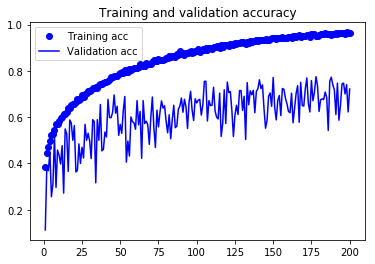

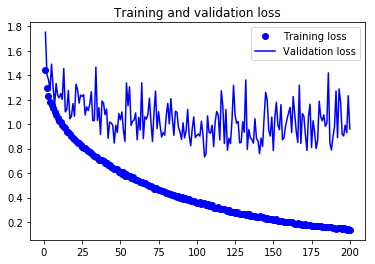

In [7]:
#plotting the result
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Train
pred_label = model1.predict(train_feature)
matrix = confusion_matrix(train_labels.argmax(axis=1), pred_label.argmax(axis=1))
print(classification_report(train_labels.argmax(axis=1), pred_label.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       774
          1       0.98      0.97      0.98       564
          2       1.00      0.98      0.99       900
          3       0.99      0.99      0.99       724
          4       0.98      0.99      0.99       632

avg / total       0.99      0.99      0.99      3594



In [9]:
#Validation
pred_label = model1.predict(validation_feature)
matrix = confusion_matrix(validation_labels.argmax(axis=1), pred_label.argmax(axis=1))
print(classification_report(validation_labels.argmax(axis=1), pred_label.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.88      0.94      0.91       126
          1       0.95      0.54      0.69       333
          2       0.00      0.00      0.00         0
          3       0.93      0.88      0.90       174
          4       0.95      0.74      0.83       265

avg / total       0.93      0.72      0.80       898



/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [10]:
#Test
pred_label = model1.predict(test_feature)
matrix = confusion_matrix(test_labels.argmax(axis=1), pred_label.argmax(axis=1))
print(classification_report(test_labels.argmax(axis=1), pred_label.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.84      0.93      0.88        60
          1       0.34      0.35      0.35        37
          2       0.41      0.15      0.22        60
          3       0.12      0.26      0.17        19
          4       0.34      0.43      0.38        30

avg / total       0.49      0.47      0.45       206



In [21]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 6,424,069
Trainable params: 6,424,069
Non-trainable params: 0
_________________________________________________________________


### CNN with Tunning Layers of VGG16


In [1]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/project/msca/projects/MLproject/machine_learning/'
train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')
#test_dir = os.path.join(base_dir, 'test')


train_df = pd.read_csv(base_dir+"train.csv")
test_df = pd.read_csv(base_dir+"test_df.csv")

train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'
test_df['diagnosis'] = test_df['diagnosis'].astype('str')
test_df['id_code'] = test_df['id_code'].astype(str)+'.png'

/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.20)

batch_size = 20


train_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    class_mode="categorical",
    target_size=(224, 224),
    shuffle = False,
    subset='training')


valid_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    class_mode="categorical", 
    target_size=(224,224),
    shuffle = False,
    subset='validation')

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [3]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [6]:
from keras import models
from keras import layers
from keras import optimizers

def build_model():
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
    return model

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
mc = ModelCheckpoint('VGG16_tunning.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

model = build_model()

history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=147,
                              epochs=50,
                              validation_data=valid_gen,
                              validation_steps=37,
                              callbacks = [es, mc], 
                              use_multiprocessing = True,
                              verbose=1)

Epoch 1/50
147/147 [==============================] - 663s 5s/step - loss: 0.8397 - acc: 0.7058 - val_loss: 0.7698 - val_acc: 0.7186

Epoch 00001: val_loss improved from inf to 0.76982, saving model to VGG16_tunning.h5
Epoch 2/50
147/147 [==============================] - 628s 4s/step - loss: 0.7030 - acc: 0.7459 - val_loss: 0.7246 - val_acc: 0.7227

Epoch 00002: val_loss improved from 0.76982 to 0.72457, saving model to VGG16_tunning.h5
Epoch 3/50
147/147 [==============================] - 631s 4s/step - loss: 0.6406 - acc: 0.7602 - val_loss: 0.6932 - val_acc: 0.7309

Epoch 00003: val_loss improved from 0.72457 to 0.69321, saving model to VGG16_tunning.h5
Epoch 4/50
147/147 [==============================] - 632s 4s/step - loss: 0.5909 - acc: 0.7796 - val_loss: 0.6747 - val_acc: 0.7445

Epoch 00004: val_loss improved from 0.69321 to 0.67468, saving model to VGG16_tunning.h5
Epoch 5/50
147/147 [==============================] - 639s 4s/step - loss: 0.5501 - acc: 0.7942 - val_loss: 0.66

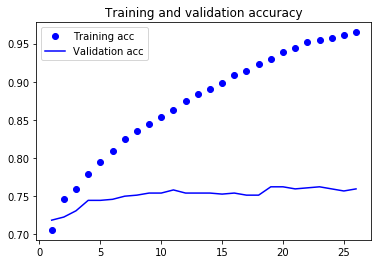

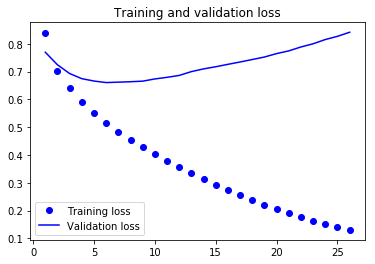

In [8]:
#plotting the result
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
test_loss, test_acc = model.evaluate_generator(generator=valid_gen,steps=len(valid_gen))

In [10]:
test_acc

0.7595628444614306

In [13]:
from keras.models import load_model
model = load_model('VGG16_tunning.h5')
test_loss, test_acc = model.evaluate_generator(generator=valid_gen,steps=len(valid_gen))
test_acc

0.7459016416242213

In [14]:
train_loss, train_acc = model.evaluate_generator(generator=train_gen,steps=len(train_gen))
train_acc

0.8153583616933725

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
valid_gen.reset()
Y_pred = model.predict_generator(valid_gen, steps = 732//20+1 ) #num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))
print(classification_report(valid_gen.classes, y_pred))

Confusion Matrix
[[328   3   6   0   0]
 [  6  30  39   1   1]
 [ 19  19 181   2   0]
 [  2   1  30   3   2]
 [  3   5  45   2   4]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       337
          1       0.52      0.39      0.44        77
          2       0.60      0.82      0.69       221
          3       0.38      0.08      0.13        38
          4       0.57      0.07      0.12        59

avg / total       0.72      0.75      0.71       732



In [18]:
train_gen.reset()
Y_pred = model.predict_generator(train_gen, steps = 2930//20+1 ) #num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_gen.classes, y_pred))
print(classification_report(train_gen.classes, y_pred))

Confusion Matrix
[[1452    9    7    0    0]
 [  37  167   88    1    0]
 [  49   33  694    2    0]
 [   7    5  103   40    0]
 [  16   21  158    5   36]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      1468
          1       0.71      0.57      0.63       293
          2       0.66      0.89      0.76       778
          3       0.83      0.26      0.39       155
          4       1.00      0.15      0.26       236

avg / total       0.84      0.82      0.79      2930



In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 21,138,757
Trainable params: 13,503,493
Non-trainable params: 7,635,264
_________________________________________________________________
